In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, auc, roc_curve, average_precision_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [3]:
model_save_loc = "../models/asteroid/best_model1.pt"
dataset_loc = "../data/asteroids.csv"

In [62]:
# Load Data
raw_dataset = pd.read_csv(dataset_loc)

/tmp/ipykernel_3713/3195900722.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dataset = pd.read_csv(dataset_loc)


In [5]:
raw_dataset["diameter_missing"] = raw_dataset["diameter"].isna().astype(int)
raw_dataset["pha"] = raw_dataset["pha"].map({"Y": 1.0, "N" : 0.0})
raw_dataset = raw_dataset[raw_dataset["pha"].isin([1.0,0.0])]

In [ ]:
dataset = raw_dataset[raw_dataset["neo"] == "Y"]

features = ["H", "epoch", "diameter_missing", "epoch_mjd", "e", "a", "q", "i", "om", "w", "rms", "per", "per_y"]
target = "pha"

dataset[target].value_counts()


,1565
H,1.690000e+01
epoch,2.459000e+06
diameter_missing,0.000000e+00
epoch_mjd,5.900000e+04
e,8.270213e-01
a,1.078169e+00
q,1.865002e-01
i,2.282211e+01
om,8.799754e+01
w,3.139334e+01


In [ ]:
# # Analysis

# # print(dataset[target].info())
# # print(dataset.describe())
# # print(dataset["pha"].value_counts())

dataset["pha"].value_counts().plot(kind='bar')
plt.title("PHA vs Non-PHA Asteroids")
plt.xlabel("PHA")
plt.ylabel("Count")

dataset[features].hist(bins=3, figsize=(10,8))
plt.suptitle("Feature Distributions")
plt.show()

# # import seaborn as sns

# # for col in ["diameter", "albedo", "H", "e", "a"]:
# #     sns.boxplot(data=dataset, x="pha", y=col)
# #     plt.title(f"{col} vs PHA")
# #     plt.show()

# # sns.pairplot(dataset, vars=["diameter", "H", "albedo"], hue="pha")
# # plt.show()

In [7]:
# Split Data

train_df, test_df = train_test_split(dataset, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)


In [8]:
# Impute Missing Values

imputer = SimpleImputer(strategy='median')

train_df[features] = imputer.fit_transform(train_df[features])
val_df[features]    = imputer.transform(val_df[features])
test_df[features]   = imputer.transform(test_df[features])

In [9]:
# Scale Features

scaler = StandardScaler()

train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])



In [10]:
# Dataset & DataLoader

class AsteroidDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = AsteroidDataset(train_df, features, target)
test_dataset = AsteroidDataset(test_df, features, target)
val_dataset = AsteroidDataset(val_df, features, target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [45]:
dataz = {
    "ID": ["0000001", "0000002", "0000003", "0000004"],
    "Name": ["Ceres", "Pallas", "Juno", "Vesta"],
    "NEO": ["No", "No", "No", "No"],
    "PHA": ["No", "No", "No", "No"],
    "H (brightness)": [3.4, 4.2, 5.3, 3.0],
    "Diameter (km)": [939.4, 545.0, 246.6, 525.4],
    "Eccentricity (e)": [0.076, 0.230, 0.257, 0.089],
    "Inclination (°)": [10.59, 34.83, 12.99, 7.14],
    "MOID (AU)": [1.5948, 1.2343, 1.0343, 1.1395]
}

dfz = pd.DataFrame(dataz)
dfz

,ID,Name,NEO,PHA,H (brightness),Diameter (km),Eccentricity (e),Inclination (°),MOID (AU)
0,0000001,Ceres,No,No,3.4,939.4,0.076,10.59,1.5948
1,0000002,Pallas,No,No,4.2,545.0,0.230,34.83,1.2343
2,0000003,Juno,No,No,5.3,246.6,0.257,12.99,1.0343
3,0000004,Vesta,No,No,3.0,525.4,0.089,7.14,1.1395


In [11]:
# Model

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.bn = nn.LayerNorm(dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return self.bn2(out + x)

class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_blocks=3, output_dim=1, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.LayerNorm(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)])
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.blocks(out)
        out = self.fc2(out)
        return out

In [29]:
# Model Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network(len(features)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [30]:
pos_weight = train_df[train_df["pha"] == 0.0].size / train_df[train_df["pha"] == 1.0].size
pos_weight = torch.tensor([pos_weight]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [31]:
# Validation

def validate():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits.squeeze(), y)
            total_loss += loss.item() * X.size(0)

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds.squeeze() == y).sum().item()
            total += y.size(0)

    print(f"Validation Loss: {total_loss/total:.4f} | Validation Accuracy: {correct/total:.4f}")

In [32]:
def get_pr_auc():
    model.eval()
    all_logits = []
    all_targets = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x).squeeze()
            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())

    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)

    probs = torch.sigmoid(all_logits).numpy()
    targets = all_targets.numpy()

    precision, recall, _ = precision_recall_curve(targets, probs)
    pr_auc = auc(recall, precision)

    return pr_auc

In [33]:
def train(epochs=3000):
    best_pr_auc = 0
    patience = 20
    trigger = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X,y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits.squeeze(), y)
            loss.backward()
            optimizer.step()

            # Tracking
            total_loss += loss.item() * X.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds.squeeze() == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch}: Train Loss = {total_loss/total:.4f} | Train Acc: {correct/total:.4f}")
        validate()

        current_pr_auc = get_pr_auc()

        print(f"PR-AUC: {current_pr_auc:.4f}")

        if current_pr_auc > best_pr_auc:
            best_pr_auc = current_pr_auc
            trigger = 0
            torch.save(model.state_dict(), model_save_loc)
            print("New model saved!")
        else:
            trigger += 1
            if trigger >= patience:
                break

train()

Epoch 0: Train Loss = 0.6463 | Train Acc: 0.7900
Validation Loss: 0.5654 | Validation Accuracy: 0.8010
PR-AUC: 0.4934
New model saved!
Epoch 1: Train Loss = 0.5609 | Train Acc: 0.8038
Validation Loss: 0.4868 | Validation Accuracy: 0.8130
PR-AUC: 0.5666
New model saved!
Epoch 2: Train Loss = 0.5134 | Train Acc: 0.8144
Validation Loss: 0.4606 | Validation Accuracy: 0.8212
PR-AUC: 0.5950
New model saved!
Epoch 3: Train Loss = 0.4998 | Train Acc: 0.8193
Validation Loss: 0.4478 | Validation Accuracy: 0.8320
PR-AUC: 0.6219
New model saved!
Epoch 4: Train Loss = 0.4891 | Train Acc: 0.8220
Validation Loss: 0.4513 | Validation Accuracy: 0.8237
PR-AUC: 0.5981
Epoch 5: Train Loss = 0.4795 | Train Acc: 0.8272
Validation Loss: 0.4351 | Validation Accuracy: 0.8445
PR-AUC: 0.6214
Epoch 6: Train Loss = 0.4888 | Train Acc: 0.8235
Validation Loss: 0.4486 | Validation Accuracy: 0.8234
PR-AUC: 0.6191
Epoch 7: Train Loss = 0.4649 | Train Acc: 0.8334
Validation Loss: 0.4184 | Validation Accuracy: 0.8395
PR-

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

def load():
    model = Network(len(features)).to(device)
    model.load_state_dict(torch.load(model_save_loc))
    return model

model = load()
    

In [44]:
from sklearn.metrics import classification_report

def test():
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    total_loss = 0
    all_logits = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)

            loss = criterion(logits.squeeze(), y)
            total_loss += loss.item()

            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())
            
            preds = (torch.sigmoid(logits) > 0.83).float()

            tp += torch.logical_and(y, preds.squeeze()).sum().item()
            tn += torch.logical_not(torch.logical_or(y, preds.squeeze())).sum().item()
            fp += torch.logical_and(preds.squeeze(), torch.logical_not(y)).sum().item()
            fn += torch.logical_and(y, torch.logical_not(preds.squeeze())).sum().item()

    all_logits = torch.cat(all_logits).numpy()
    all_targets = torch.cat(all_targets).numpy()

    probs = 1 / (1 + np.exp(-all_logits))

    # Classification labels using SAME threshold
    y_pred = (probs > 0.83).astype(int)

    # PR-AUC
    precision, recall, thresholds = precision_recall_curve(all_targets, probs)
    pr_auc = auc(recall, precision)

    print(f"\nTest Metrics:")
    print(f"Accuracy={(tp + tn)/(tp + tn + fp + fn):.4f}")
    print(f"Precision={(tp/(tp + fp)):.4f}")
    print(f"Recall={(tp/(fn + tp)):.4f}")
    print(f"F1={(2 * tp)/((2 * tp) + (fp + fn)):.4f}")
    print(f"PR-AUC={pr_auc:.4f}\n")

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(
        all_targets,
        y_pred,
        target_names=["Not Hazardous", "Potentially Hazardous"]
    ))

test()


Test Metrics:
Accuracy=0.9950
Precision=0.9555
Recall=0.9920
F1=0.9734
PR-AUC=0.9974

Classification Report:

                       precision    recall  f1-score   support

        Not Hazardous       1.00      1.00      1.00      6240
Potentially Hazardous       0.96      0.99      0.97       628

             accuracy                           1.00      6868
            macro avg       0.98      0.99      0.99      6868
         weighted avg       1.00      1.00      1.00      6868



# Metrics

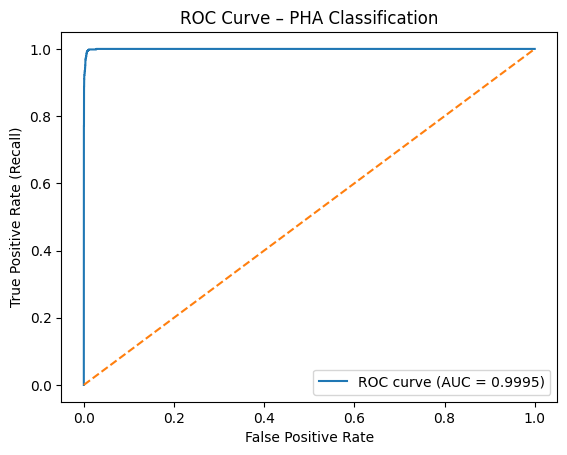

In [100]:
# ROC Curve

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        probs = torch.sigmoid(logits).squeeze()

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# ROC data
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – PHA Classification")
plt.legend()
plt.show()

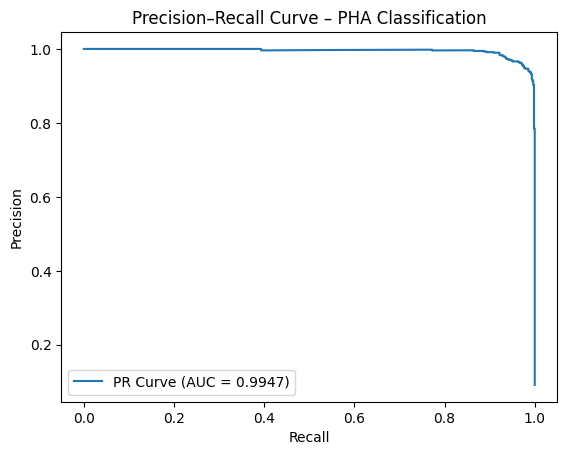

In [101]:
# PRC Curve

precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

plt.figure()
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – PHA Classification")
plt.legend()
plt.show()

/home/emmanuel/Programming/Data_Science/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


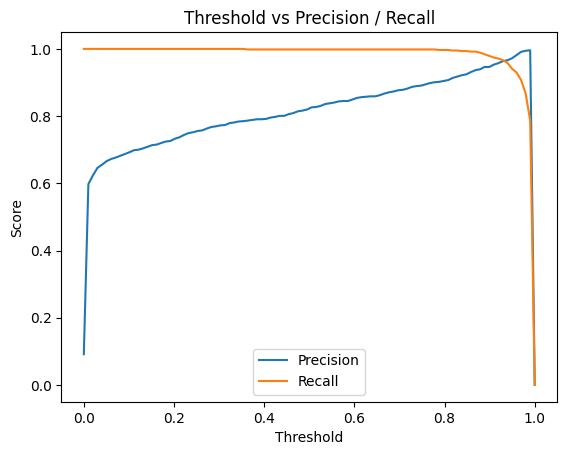

In [102]:
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

for thresh in thresholds:
    preds = (np.array(all_probs) >= thresh).astype(int)
    precisions.append(precision_score(all_labels, preds))
    recalls.append(recall_score(all_labels, preds))

plt.figure()
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall")
plt.legend()
plt.show()

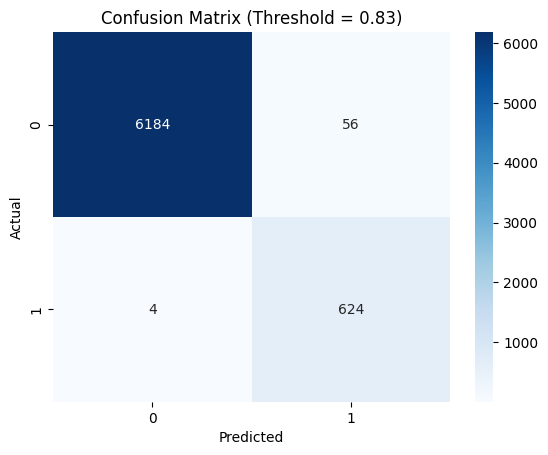

In [104]:
# Confusion Matrix

threshold = 0.83   # change to your chosen value
preds = (np.array(all_probs) >= threshold).astype(int)

cm = confusion_matrix(all_labels, preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.83)")
plt.show()

# Baselines

In [21]:
# Baselines

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

X_train = train_df[features].values
y_train = train_df[target].values

X_val = val_df[features].values
y_val = val_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

# Class weight handles imbalance
log_model = LogisticRegression(class_weight="balanced", max_iter=1000)

log_model.fit(X_train, y_train)

# Predictions
y_probs = log_model.predict_proba(X_test)[:, 1]
y_preds = (y_probs >= 0.5).astype(int)

# Metrics
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_preds))

print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("PR AUC:", average_precision_score(y_test, y_probs))



Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      6240
         1.0       0.28      0.85      0.42       628

    accuracy                           0.79      6868
   macro avg       0.63      0.82      0.65      6868
weighted avg       0.92      0.79      0.83      6868

ROC AUC: 0.87536568063041
PR AUC: 0.30647574889633433


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

y_probs = rf_model.predict_proba(X_test)[:, 1]
y_preds = (y_probs >= 0.5).astype(int)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_preds))

print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("PR AUC:", average_precision_score(y_test, y_probs))



Random Forest Results:
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      6240
         1.0       0.44      1.00      0.62       628

    accuracy                           0.89      6868
   macro avg       0.72      0.94      0.77      6868
weighted avg       0.95      0.89      0.90      6868

ROC AUC: 0.9845891005226195
PR AUC: 0.8432737168583601


In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_probs = knn.predict_proba(X_test)[:, 1]
y_preds = (y_probs >= 0.5).astype(int)

print("\nKNN Results:")
print(classification_report(y_test, y_preds))

print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("PR AUC:", average_precision_score(y_test, y_probs))



KNN Results:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      6240
         1.0       0.77      0.32      0.46       628

    accuracy                           0.93      6868
   macro avg       0.86      0.66      0.71      6868
weighted avg       0.92      0.93      0.92      6868

ROC AUC: 0.9552153509309163
PR AUC: 0.6462945328991923


In [28]:
# Threshold-based "physics rule" baseline
preds = ((test_df["H"] < 22) & (test_df["moid"] < 0.05)).astype(int)

print("\nPhysics Rule Baseline:")
print(classification_report(y_test, preds))



Physics Rule Baseline:
              precision    recall  f1-score   support

         0.0       1.00      0.56      0.72      6240
         1.0       0.19      1.00      0.32       628

    accuracy                           0.60      6868
   macro avg       0.59      0.78      0.52      6868
weighted avg       0.93      0.60      0.68      6868



# Single Instance Testing

In [68]:
def predict_single_asteroid(asteroid_features, scaler, model, device, threshold=0.83):
    """
    asteroid_features: list or np.array in the exact order of FEATURE_NAMES
    scaler: fitted StandardScaler
    model: trained PyTorch model
    device: 'cuda' or 'cpu'
    threshold: PHA decision threshold

    Returns: (prediction, probability)
    """

    assert len(asteroid_features) == 13, \
        f"Expected 13 features, got {len(asteroid_features)}"

    model.eval()

    # Convert -> scale -> tensor
    x = pd.DataFrame([asteroid_features], columns=features)
    x_scaled = scaler.transform(x)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(x_tensor)
        prob = torch.sigmoid(logits).item()
        pred = 1 if prob > threshold else 0

    label = "PHA (Potentially Hazardous Asteroid)" if pred == 1 else "Non-PHA"

    print("\n===== Asteroid Risk Assessment =====")
    for name, val in zip(features, asteroid_features):
        print(f"{name:<18} : {val}")
    print("------------------------------------")
    print(f"PHA Probability : {prob:.4f}")
    print(f"Classification  : {label}")
    print("====================================\n")

    return pred, prob

In [69]:
safe_asteroid = [
    26.5,      # H (dim = small)
    2459000,   # epoch
    1,         # diameter_missing (1 = missing → small/unknown)
    59000,     # epoch_mjd

    0.05,      # e (almost circular)
    2.8,       # a (main belt)
    2.65,      # q (nowhere near Earth)
    1.2,       # i (flat orbit)
    45.0,      # om
    120.0,     # w
    0.3,       # rms (good quality orbit)
    1700,      # per (days)
    4.65       # per_y (years)
]

predict_single_asteroid(safe_asteroid, scaler, model, device)


===== Asteroid Risk Assessment =====
H                  : 26.5
epoch              : 2459000
diameter_missing   : 1
epoch_mjd          : 59000
e                  : 0.05
a                  : 2.8
q                  : 2.65
i                  : 1.2
om                 : 45.0
w                  : 120.0
rms                : 0.3
per                : 1700
per_y              : 4.65
------------------------------------
PHA Probability : 0.0001
Classification  : Non-PHA



(0, 7.869358523748815e-05)

In [ ]:
doom_asteroid = [
    12.0,      # H (very bright and massive)
    2459000,   # epoch
    0,         # diameter_missing (0 = known)
    59000,     # epoch_mjd
    0.985,     # e (very stretched orbit)
    1.02,      # a (Earth-crossing)
    0.25,      # q (crosses Earth's orbit HARD)
    0.0001,    # i (PERFECT alignment)
    0.0,       # om (lined up)
    0.0,       # w (lined up)
    0.01,      # rms (very precise track)
    370,       # per (1 year-ish)
    1.01       # per_y (close to Earth’s period -> catastrophic)
]

predict_single_asteroid(doom_asteroid, scaler, model, device)


===== Asteroid Risk Assessment =====
H                  : 12.0
epoch              : 2459000
diameter_missing   : 0
epoch_mjd          : 59000
e                  : 0.985
a                  : 1.02
q                  : 0.25
i                  : 0.0001
om                 : 0.0
w                  : 0.0
rms                : 0.01
per                : 370
per_y              : 1.01
------------------------------------
PHA Probability : 0.9994
Classification  : PHA (Potentially Hazardous Asteroid)



(1, 0.99944669008255)